In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

In [2]:
import os
os.chdir('/path/to/life_regression') # CHANGE THIS TO THE ROOT OF THE DIRECTORY
print(f'{os.getcwd()=}')
from IPython.display import display

os.getcwd()='/nfs3-p1/cjw/vipa208/workspace/MultiModal/life_regression'


In [3]:
checkpoint_dir = '/path/to/checkpoint/directory' # CHANGE THIS TO THE ROOT OF THE CHECKPOINT DIRECTORY

In [4]:
import torch
from pytorch_lightning.profiler import PassThroughProfiler
from tv.pl_module import ViTPlModule
import yaml

config = yaml.safe_load(open(os.path.join(checkpoint_dir, 'hparams.yaml'), 'r'))

device = 'cpu'
pl_module = ViTPlModule(config, PassThroughProfiler())
pl_module.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'checkpoints/last.ckpt'))['state_dict'])
model = pl_module.model

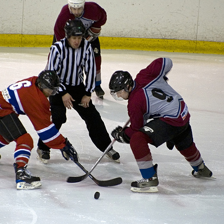

In [5]:
from tv.common import eval_timm_image_transform
from torchvision.transforms import Compose, Resize, CenterCrop, InterpolationMode
import PIL.Image

get_images = [
    lambda : PIL.Image.open('./images/ILSVRC2012_val_00003821.JPEG'),
    lambda : PIL.Image.open('./images/ILSVRC2012_val_00000599.JPEG'),
    lambda : PIL.Image.open('./images/ILSVRC2012_val_00005302.JPEG'),
    lambda : PIL.Image.open('./images/ILSVRC2012_val_00000454.JPEG'),
]

image = get_images[3]()
full_transform = eval_timm_image_transform(model_name='vit_small_patch16_224')
image_transform = Compose([
    Resize(size=248, interpolation=InterpolationMode.BICUBIC, max_size=None, antialias=None),
    CenterCrop(size=224),
])
real_image = image_transform(image)
display(real_image)
_, real_life = model(full_transform(image).unsqueeze(0))

In [6]:
from torch import Tensor


def visualize_life(life: Tensor, image: PIL.Image.Image):
    """
    :param life: (N,)
    :param image:
    :return:
    """
    import seaborn
    mask = life[1:].view(14, 14).clamp(max=12).detach()
    hmap = seaborn.heatmap(mask, alpha=0.7, annot=True, zorder=2, cbar=False, square=True, xticklabels=False, yticklabels=False)
    hmap.imshow(image, aspect=hmap.get_aspect(), extent = hmap.get_xlim() + hmap.get_ylim(), zorder=1)

def visualize_mask(mask: Tensor, image: PIL.Image.Image):
    import seaborn
    mask = mask[1:].view(14, 14).detach()
    hmap = seaborn.heatmap(mask, alpha=0.7, zorder=2, cbar=False, square=True, xticklabels=False, yticklabels=False)
    hmap.imshow(image, aspect=hmap.get_aspect(), extent = hmap.get_xlim() + hmap.get_ylim(), zorder=1)

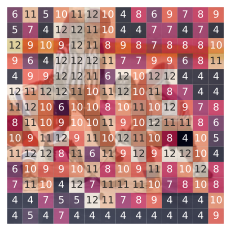

In [7]:
lifes = real_life.clamp(4, 12)[0].round()
visualize_life(lifes, real_image)

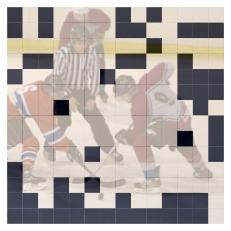

In [8]:
lifes2 = lifes.clone()
lifes2[0] = 1e+5 # cls
indices = lifes2.argsort(descending=True)
num_patches_per_layers = model.blocks.num_patches_per_layers
lifes2 = [4 for _ in range(len(indices))]
for layer_idx, num_patches in zip(range(5, 12 + 1), num_patches_per_layers):
    for idx in indices[:num_patches]:
        lifes2[idx] = layer_idx
lifes2 = torch.tensor(lifes2)
visualize_mask(lifes2 >= 5, real_image)

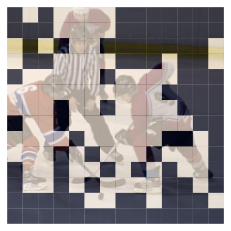

In [9]:
visualize_mask(lifes2 >= 8, real_image)

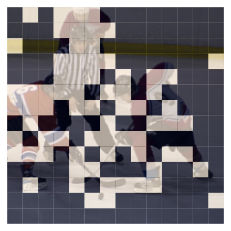

In [10]:
visualize_mask(lifes2 >= 11, real_image)